# Benchmarking Annotation Storage

First we define a function to generate some test data. here we create some simple artificial cell boundaries by creating a circle of points, adding some noise, scale to introduce eccentricity, and then rotating. We use 20 points per cell, which is a reasonably high value for cell annotation. However, this can be adjusted.

In [1]:
import sys

sys.path.append("..")  # If running locally without pypi installed tiatoolbox

from typing import Tuple, Generator, List, Optional
from numbers import Number

import numpy as np

from tiatoolbox.annotation.storage import Polygon


def cell_polygon(
    xy: Tuple[Number, Number],
    n_points: int = 20,
    radius: Number = 10,
    noise: Number = 1,
    eccentricity: Tuple[Number, Number] = (1, 3),
    repeat_first: bool = True,
    direction: str = "CCW",
    seed: int = None,
) -> Polygon:
    """Generate an aritifical cell boundary polygon.

    This is modified from the tiatoolbox unit tests.

    Cell boundaries are generated an ellipsoids with randomised eccentricity,
    added noise, and a random rotation.

    Args:
        xy (tuple(int)): The x,y centre point to generate the cell boundary around.
        n_points (int): Number of points in the boundary. Defaults to 20.
        radius (float): Radius of the points from the centre. Defaults to 10.
        noise (float): Noise to add to the point locations. Defaults to 1.
        eccentricity (tuple(float)): Range of values (low, high) to use for
            randomised eccentricity. Defaults to (1, 3).
        repeat_first (bool): Enforce that the last point is equal to the first.
        direction (str): Ordering of the points. Defaults to "CCW". Valid options
            are: counter-clockwise "CCW", and clockwise "CW".

    """
    from shapely import affinity

    if seed is not None:
        random_state = np.random.get_state()
        np.random.seed(seed)

    if repeat_first:
        n_points -= 1

    # Generate points about an ellipse with random eccentricity
    x, y = xy
    alpha = np.linspace(0, 2 * np.pi - (2 * np.pi / n_points), n_points)
    rx = radius * (np.random.rand() + 0.5)
    ry = np.random.uniform(*eccentricity) * radius - rx
    x = rx * np.cos(alpha) + x + (np.random.rand(n_points) - 0.5) * noise
    y = ry * np.sin(alpha) + y + (np.random.rand(n_points) - 0.5) * noise
    boundary_coords = np.stack([x, y], axis=1).astype(int).tolist()

    # Copy first coordinate to the end if required
    if repeat_first:
        boundary_coords = boundary_coords + [boundary_coords[0]]

    # Swap direction
    if direction.strip().lower() == "cw":
        boundary_coords = boundary_coords[::-1]

    polygon = Polygon(boundary_coords)

    # Add random rotation
    angle = np.random.rand() * 360

    if seed is not None:
        np.random.set_state(random_state)

    return affinity.rotate(polygon, angle, origin="centroid").buffer(1)


|2022-03-24|01:00:40.542| [WARNING] /home/john/miniforge3/envs/tiatoolbox-dev/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/john/miniforge3/envs/tiatoolbox-dev/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")



## Display Some Examples Cell Boundaries

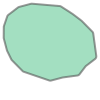

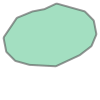

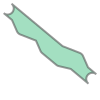

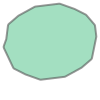

In [2]:
from IPython.display import display


for n in range(4):
    display(cell_polygon(xy=(0, 0), n_points=20, repeat_first=False, seed=n))

## Create a Dataset of Cell Boundaries

Here we create a function to generate grid of cells for testing. It uses a fixed seed for reproducibility.

In [3]:
def cell_grid(
    size: Tuple[int, int] = (10, 10), spacing: Number = 25
) -> Generator[Polygon, None, None]:
    return (
        cell_polygon(xy=np.multiply(ij, spacing), repeat_first=False, seed=n)
        for n, ij in enumerate(np.ndindex(size))
    )

## Display a Sample 5×5 Grid

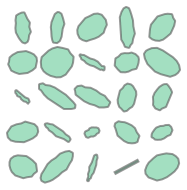

In [4]:
from shapely.geometry import MultiPolygon

MultiPolygon(polygons=list(cell_grid(size=(5, 5), spacing=35)))

## Time Creating Different Kinds of Annotation Store Objects

Here we test:

1. A python dictionary based in-memory store (DictionaryStore)
2. An SQLite database based in-memory store (SQLiteStore)

In [5]:
import timeit

from matplotlib import pyplot as plt

plt.style.use("ggplot")

from tiatoolbox.annotation.storage import Annotation, DictionaryStore, SQLiteStore


def plot_results(experiments: List[List[Number]], title: str, capsize=5, **kwargs) -> None:
    """Plot the results of a benchmark.

    Uses the min for the bar height (see See
    https://docs.python.org/2/library/timeit.html#timeit.Timer.repeat),
    and plots a min-max error bar.
    """
    x = range(len(experiments))
    color = [f"C{x_i}" for x_i in x]
    plt.bar(
        x=x,
        height=[min(e) for e in experiments],
        color=color,
        yerr=[[0 for e in experiments], [max(e) - min(e) for e in experiments]],
        capsize=capsize,
        **kwargs,
    )
    for i, (runs, c) in enumerate(zip(experiments, color)):
        plt.text(i, min(runs), f"  {min(runs):.4f}s", ha="left", va="bottom", color=c)
    plt.title(title)
    plt.xlabel("Store Type")
    plt.ylabel("Time (s)")


In [6]:
# Convert to annotations (a dataclass paring a geometry and (optional)
# key-value properties)
annotations = [Annotation(polygon) for polygon in cell_grid(size=(100, 100), spacing=35)]

In [28]:
# Time dictionary store
dict_runs = timeit.repeat(
    "dict_store.append_many(annotations)",
    setup="dict_store = DictionaryStore()",
    globals={"DictionaryStore": DictionaryStore, "annotations": annotations},
    number=3,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    "sql_store.append_many(annotations)",
    setup="sql_store = SQLiteStore()",
    globals={"SQLiteStore": SQLiteStore, "annotations": annotations},
    number=3,
)

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Time to Append 10000 Annotations",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

Note that inserting into the `SQLiteStore` is much slower than the
`DictionaryStore`. This is because the R-Tree spatial index must be
updated, which is a relatively expensive operation. However, this
spatial index allows for very fast queries within a given region.
Insertion is typically only performed once for each annotation, whereas
queries may be performed many times on the annotation set. Therefore, it
makes sense to trade a more expensive insertion for fast queries.

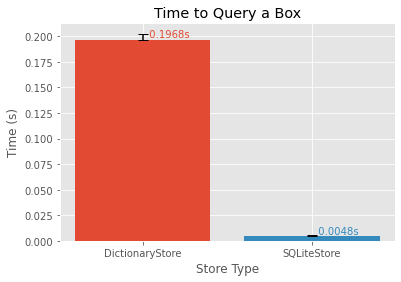

In [8]:
# One time Setup
dict_store = DictionaryStore()
sql_store = SQLiteStore()
dict_store.append_many(annotations)
sql_store.append_many(annotations)
box = Polygon.from_bounds(50, 50, 100, 100)

# Time dictionary store
dict_runs = timeit.repeat(
    "dict_store.query(box)",
    globals={"dict_store": dict_store, "box": box},
    number=10,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    "sql_store.query(box)",
    globals={"sql_store": sql_store, "box": box},
    number=10,
)

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Time to Query a Box",
    tick_label=["DictionaryStore", "SQLiteStore"],
)

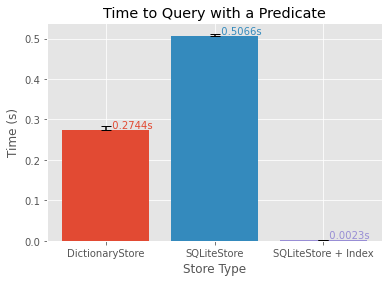

In [9]:
# Setup
import copy

labelled_annotations = copy.deepcopy(annotations)
for n, annotation in enumerate(labelled_annotations):
    annotation.properties["class"] = n

box = Polygon.from_bounds(0, 0, 1000, 1000)
predicate = "props['class'] == 0"

dict_store = DictionaryStore()
sql_store = SQLiteStore()

dict_store.append_many(labelled_annotations)
sql_store.append_many(labelled_annotations)


# Time dictionary store
dict_runs = timeit.repeat(
    "store.query(box, where=predicate)",
    globals={"store": dict_store, "box": box, "predicate": predicate},
    number=10,
)
dict_result = dict_store.query(box, where=predicate)

# Time SQLite store
sqlite_runs = timeit.repeat(
    "store.query(box, where=predicate)",
    globals={"store": sql_store, "box": box, "predicate": predicate},
    number=10,
)
sql_result = sql_store.query(box, where=predicate)


# Add an index
sql_store.create_index("class_lookup", "props['class']")

# Time SQLite store again
sqlite_index_runs = timeit.repeat(
    "store.query(box, where=predicate)",
    globals={"store": sql_store, "box": box, "predicate": predicate},
    number=10,
)
sql_index_result = sql_store.query(box, where=predicate)


# Validate the results against each other
for a, b, c in zip(dict_result, sql_result, sql_index_result):
    assert a.geometry == b.geometry == c.geometry

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs, sqlite_index_runs],
    title="Time to Query with a Predicate",
    tick_label=["DictionaryStore", "SQLiteStore", "SQLiteStore + Index"],
)

# Serialising and Deserialising To/From Disk